In [4]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pandas as pd
from scipy import ndimage as nd
import pickle
import program_functions as pf
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
# To begin, let's import the non-labeled raw image
img = cv2.imread('images/train_nonlabel.tif',0)

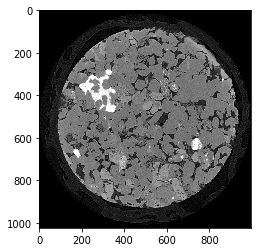

In [3]:
plt.imshow(img, cmap = 'gray')
plt.show()

In [6]:
# Now let's do feature extraction and get the 62 feature variables in the form of a dataframe table
df = pd.DataFrame()
df = pf.get_features(img)
df

,pixel,Gabor1,Gabor2,Gabor3,Gabor4,Gabor5,Gabor6,Gabor7,Gabor8,Gabor9,...,Scharr_Edge,Prewitt_Edge,Gaussian3,Gaussian5,Gaussian7,Gaussian9,Median3,Median5,Median7,Median9
0,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1019899,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0,0,0,0,0,0,0,0
1019900,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0,0,0,0,0,0,0,0
1019901,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0,0,0,0,0,0,0,0
1019902,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0,0,0,0,0,0,0,0


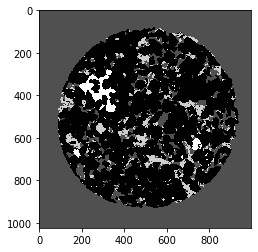

In [18]:
# Now add class label column
img_class = cv2.imread('images/train_label.tif',0)
plt.imshow(img_class, cmap='gray')
img_class_reshape = img_class.reshape(-1)
df['class'] = img_class_reshape

In [19]:
# Get the unique pixel count to check if there are 4 class labels
class_labels = pd.DataFrame(df['class'].value_counts()).reset_index(drop=False)
class_labels.columns = ['Pixel Value', 'Pixel Count']
class_labels

,Pixel Value,Pixel Count
0,76,522177
1,29,437060
2,150,45675
3,179,14992


In [20]:
# Now we can split the data into 90:10 train:test ratio and begin machine learning
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(df.iloc[:,0:-1].values, df.iloc[:,-1].values, test_size = 0.1, random_state = 10)

In [21]:
#The machine learning algorithm for training (Random Forest Classifier)
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators = 100, min_samples_split = 2, n_jobs = -1, random_state = 10, verbose = 0)

In [23]:
model.fit(x_train, y_train)

RandomForestClassifier(n_jobs=-1, random_state=10)

In [25]:
y_pred = model.predict(x_test)

In [26]:
def get_acc(matches):
    return sum(matches)/len(matches)

In [27]:
# Compare predicted result with real test values to calculate accuracy
matches = [1 if i==j else 0 for i,j in zip(y_pred,y_test)]

In [28]:
get_acc(matches)

0.9860477885303606

In [29]:
feat_list = pd.DataFrame()
feat_list['Features'] = df.columns[:-1]
feat_list['Impt Score'] = model.feature_importances_

In [30]:
feat_list = feat_list.sort_values('Impt Score', ascending = False).reset_index(drop=True)
feat_list.head(n=10)

,Features,Impt Score
0,Median5,0.123325
1,Gaussian3,0.106966
2,Median7,0.095610
3,Median9,0.094393
4,pixel,0.075776
5,Median3,0.062840
6,Gaussian5,0.048110
7,Gabor31,0.047365
8,Gabor24,0.040370
9,Gabor23,0.040210


In [132]:
#Storing model for future use in Pickle format

In [134]:
filename = 'sandstone_train.pickle'
#Write in binary format
pickle.dump(model, open(filename, 'wb'))

In [31]:
#Now pretend we want to use it back
filename = 'sandstone_train.pickle'
#Read binary format
model = pickle.load(open(filename, 'rb'))

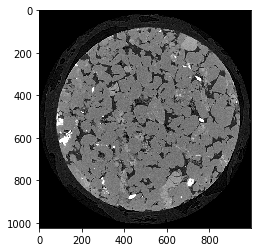

In [36]:
# Now that we have a model. We can test it on other raw sample images.
test_img = cv2.imread('images/test_sandstone1.tif',0)
plt.imshow(test_img, cmap='gray')

In [ ]:
# Calculate the 62 feature variables
df_test = pf.get_features(test_img)

In [37]:
# Run the model on the test image
y_pred = model.predict(df_test.values)

In [38]:
# Ensure results contain 4 unique pixel values as class labels
pd.Series(y_pred).value_counts()

29     505270
76     480012
150     28074
226      6548
dtype: int64

In [39]:
# Reshape the 1-D array output back into 2-D array image
orig_img_shape = img.shape
segmented_img = y_pred.reshape(img.shape)

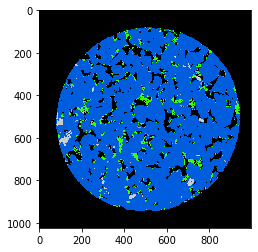

In [44]:
# Predicted image result
plt.imshow(segmented_img, cmap = 'nipy_spectral')

In [ ]:
# Save image result
plt.imsave('images/sandstone_pred2.png', segmented_img, cmap ='nipy_spectral')

In [45]:
# Now we want to calculate the composition ratios by calculating the pixel value ratios
# First, we need to ignore the black region outside of the microscope image view
# To do this, we can place a mask within the circular view and bump up the pixel values
# This way, the values inside the circular view will be different than outside the circular view

mask = np.zeros((segmented_img.shape[0],segmented_img.shape[1]),dtype=np.uint8)

In [46]:
circle = cv2.circle(mask,(510,520),420,(100,100,100),-1,8,0)

In [47]:
out = segmented_img+mask

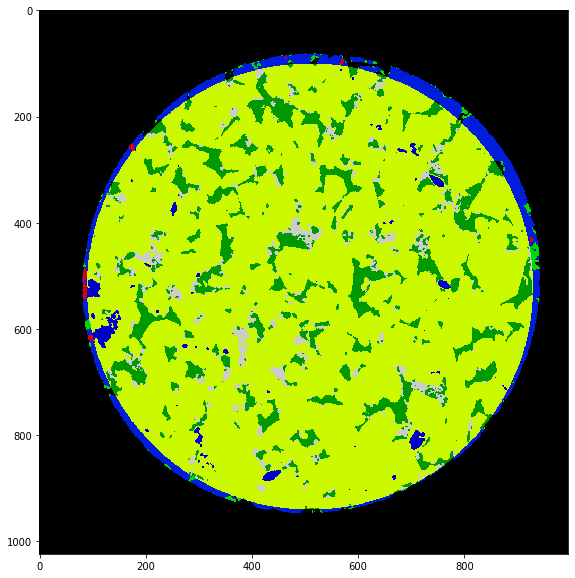

In [48]:
plt.figure(figsize=(10,10))
plt.imshow(out, cmap='nipy_spectral')

In [114]:
# The new pixel values can be shown using value_counts() function
new_pixels = pd.DataFrame(pd.Series(out.reshape(-1)).value_counts()).reset_index(drop=False)

new_pixels.columns = ['Pixel Value', 'Pixel Count']
new_pixels['Pixel Located'] = ['Inside Circle','Outside Circle', 'Inside Circle', 'Outside Circle','Inside Circle','Inside Circle', 'Outside Circle', 'Outside Circle']
new_pixels

,Pixel Value,Pixel Count,Pixel Located
0,176,453732,Inside Circle
1,29,436326,Outside Circle
2,129,68944,Inside Circle
3,76,26280,Outside Circle
4,250,25622,Inside Circle
5,70,5815,Inside Circle
6,150,2452,Outside Circle
7,226,733,Outside Circle


In [115]:
# The final composition results for pixels inside the circle are calculated and labeled in the table
pixel_composition = new_pixels[new_pixels['Pixel Located'] == 'Inside Circle']

pixel_composition['Pixel Proportion %'] = [ 100*i/pixel_composition['Pixel Count'].sum() for i in pixel_composition['Pixel Count']]
pixel_composition['Material Type'] = ['Quartz', 'Porosity', 'Clay', 'Metal']
pixel_composition

,Pixel Value,Pixel Count,Pixel Located,Pixel Proportion %,Material Type
0,176,453732,Inside Circle,81.884381,Quartz
2,129,68944,Inside Circle,12.442227,Porosity
4,250,25622,Inside Circle,4.623967,Clay
5,70,5815,Inside Circle,1.049425,Metal
